# A5 Classification with CNNs

In this assignment, you will define a new class named `NeuralNetworkClassifierCNN` that extends the `NeuralNetworkClassifier` class provided here. You will compare how your `NeuralNetworkClassifier` comapres with your `NeuralNetworkClassifierCNN` to train a classifier of Images.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
%%writefile optimizers.py
import numpy as np

######################################################################
## class Optimizers()
######################################################################

class Optimizers():

    def __init__(self, all_weights):
        '''all_weights is a vector of all of a neural networks weights concatenated into a one-dimensional vector'''
        
        self.all_weights = all_weights

        # The following initializations are only used by adam.
        # Only initializing m, v, beta1t and beta2t here allows multiple calls to adam to handle training
        # with multiple subsets (batches) of training data.
        self.mt = np.zeros_like(all_weights)
        self.vt = np.zeros_like(all_weights)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.beta1t = 1
        self.beta2t = 1

        
    def sgd(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, verbose=True, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= learning_rate * grad

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'sgd: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

    def adam(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, verbose=True, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        alpha = learning_rate  # learning rate called alpha in original paper on adam
        epsilon = 1e-8
        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            self.mt[:] = self.beta1 * self.mt + (1 - self.beta1) * grad
            self.vt[:] = self.beta2 * self.vt + (1 - self.beta2) * grad * grad
            self.beta1t *= self.beta1
            self.beta2t *= self.beta2

            m_hat = self.mt / (1 - self.beta1t)
            v_hat = self.vt / (1 - self.beta2t)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= alpha * m_hat / (np.sqrt(v_hat) + epsilon)
    
            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'Adam: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

if __name__ == '__main__':

    import matplotlib.pyplot as plt
    plt.ion()

    def parabola(wmin):
        return ((w - wmin) ** 2)[0]

    def parabola_gradient(wmin):
        return 2 * (w - wmin)

    w = np.array([0.0])
    optimizer = Optimizers(w)

    wmin = 5
    optimizer.sgd(parabola, parabola_gradient, [wmin],
                  n_epochs=500, learning_rate=0.1)

    print(f'sgd: Minimum of parabola is at {wmin}. Value found is {w}')

    w = np.array([0.0])
    optimizer = Optimizers(w)
    optimizer.adam(parabola, parabola_gradient, [wmin],
                   n_epochs=500, learning_rate=0.1)
    
    print(f'adam: Minimum of parabola is at {wmin}. Value found is {w}')

Writing optimizers.py


In [ ]:
import optimizers
import sys  # for sys.float_info.epsilon

######################################################################
## class NeuralNetwork()
######################################################################

class NeuralNetwork():


    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, activation_function='tanh'):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.activation_function = activation_function

        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        # Initialize weights, by first building list of all weight matrix shapes.
        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        # self.all_weights:  vector of all weights
        # self.Ws: list of weight matrices by layer
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Define arrays to hold gradient values.
        # One array for each W array with same shape.
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None


    def make_weights_and_views(self, shapes):
        # vector of all weights built by horizontally stacking flatenned matrices
        # for each layer initialized with uniformly-distributed values.
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        # Build list of views by reshaping corresponding elements from vector of all weights
        # into correct shape for each layer.
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views


    # Return string that shows how the constructor was called
    def __repr__(self):
        return f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs}, \'{self.activation_function}\')'


    # Return string that is more informative to the user about the state of this neural network.
    def __str__(self):
        result = self.__repr__()
        if len(self.error_trace) > 0:
            return self.__repr__() + f' trained for {len(self.error_trace)} epochs, final training error {self.error_trace[-1]:.4f}'


    def train(self, X, T, n_epochs, learning_rate, method='sgd', verbose=True):
        '''
train: 
  X: n_samples x n_inputs matrix of input samples, one per row
  T: n_samples x n_outputs matrix of target output values, one sample per row
  n_epochs: number of passes to take through all samples updating weights each pass
  learning_rate: factor controlling the step size of each update
  method: is either 'sgd' or 'adam'
        '''

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = optimizers.Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units, 
        # but only if the network has a single output. Multiplying by self.Tstds for 
        # multiple outputs does not correctly unstandardize the error.
        if len(self.Tstds) == 1:
            error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar
        else:
            error_convert_f = lambda err: np.sqrt(err)[0] # to scalar
            

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        verbose=True,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         verbose=True,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self

    def relu(self, s):
        s[s < 0] = 0
        return s

    def grad_relu(self, s):
        return (s > 0).astype(int)
    
    def forward_pass(self, X):
        '''X assumed already standardized. Output returned as standardized.'''
        self.Ys = [X]
        for W in self.Ws[:-1]:
            if self.activation_function == 'relu':
                self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            else:
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T - self.Ys[-1]
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            if self.activation_function == 'relu':
                delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(self.Ys[layeri])
            else:
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients

    def use(self, X):
        '''X assumed to not be standardized'''
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        Ys = self.forward_pass(X)
        Y = Ys[-1]
        # Unstandardize output Y before returning it
        return Y * self.Tstds + self.Tmeans

In [ ]:
class NeuralNetworkClassifier(NeuralNetwork):

  def makeIndicatorVars(self, T):
      # Make sure T is two-dimensional. Should be nSamples x 1.
      if T.ndim == 1:
          T = T.reshape((-1, 1))
      retT = (T == np.unique(T)).astype(int)
      return retT
      
  def softmax (self, X):
      fs = np.exp(X)  # N x K
      denom = np.sum(fs, axis=1).reshape((-1, 1))
      gs = fs / (denom + sys.float_info.epsilon)
      return gs

  def train(self, X, T, n_epochs, learning_rate, method='sgd', verbose=True):
        '''
train: 
  X: n_samples x n_inputs matrix of input samples, one per row
  T: n_samples x n_outputs matrix of target output values, one sample per row
  n_epochs: number of passes to take through all samples updating weights each pass
  learning_rate: factor controlling the step size of each update
  method: is either 'sgd' or 'adam'
        '''

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        self.TtrainI = self.makeIndicatorVars(T)
        self.uniqueT=np.unique(T)
        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = optimizers.Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units, 
        # but only if the network has a single output. Multiplying by self.Tstds for 
        # multiple outputs does not correctly unstandardize the error.
        error_convert_f = lambda nll: (np.exp(-nll))

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, self.TtrainI], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        verbose=True,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, self.TtrainI], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         verbose=True,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self

    # Function to be minimized by optimizer method, mean squared error  
  def error_f(self, X, T):
      temp = self.forward_pass(X)
      Y = self.softmax(temp[-1])
      #mean_sq_error = np.mean((T - Ys[-1]) ** 2)
      return - np.mean((T * np.log(Y)))


  # Gradient of function to be minimized for use by optimizer method 
  # Look at Lecture 10
  def gradient_f(self, X, T):
      Y = self.softmax(self.Ys[-1])
      delta = (Y - T) / (T.shape[0] * T.shape[1])
      n_layers = len(self.n_hiddens_per_layer) + 1
      for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            if self.activation_function == 'relu':
                delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(self.Ys[layeri])
            else:
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
      return self.all_gradients

  def use(self, X):
      Xtest = ((X - self.Xmeans)/self.Xstds)
      #Xtest1 = np.hstack(( np.ones((Xtest.shape[0],1)), Xtest))
      temp = self.forward_pass(Xtest)
      logregOutput = self.softmax(temp[-1])
      predictedTrain = np.argmax(logregOutput,axis=1)
      result = np.array(list(map(lambda x: [self.uniqueT[x].astype(int)] , predictedTrain)))
      return result , logregOutput

In [ ]:
class NeuralNetworkClassifierCNN(NeuralNetworkClassifier):
      def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, patch_size, stride, activation_function='tanh'):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.activation_function = activation_function
        self.stride = stride
        self.patch_size = patch_size 

        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        # Initialize weights, by first building list of all weight matrix shapes.
        n_in = n_inputs
        shapes = []
        # First build shape of weight matrix for convolutional layer.  Only one allowed.
        shapes = [(self.patch_size * self.patch_size + 1, n_hiddens_per_layer[0])]
        input_size = int(np.sqrt(n_inputs))
        n_in = ((input_size - self.patch_size) // self.stride + 1) ** 2 * self.n_hiddens_per_layer[0]
        for nh in self.n_hiddens_per_layer[1:]:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, self.n_outputs))

        # self.all_weights:  vector of all weights
        # self.Ws: list of weight matrices by layer
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Define arrays to hold gradient values.
        # One array for each W array with same shape.
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None

      def _make_patches(self, X, patch_size, stride=1):
        '''X: n_samples x n_pixels  (flattened square images)'''
        X = np.ascontiguousarray(X)  # make sure X values are contiguous in memory
        n_samples = X.shape[0]
        image_size = int(np.sqrt(X.shape[1]))
        n_patches = (image_size - patch_size ) // stride + 1
        nb = X.itemsize  # number of bytes each value
        new_shape = [n_samples, n_patches, n_patches, patch_size, patch_size]
        new_strides = [image_size * image_size * nb,
                        image_size * stride * nb,
                        stride * nb,
                        image_size * nb,
                        nb]
        X = np.lib.stride_tricks.as_strided(X, shape=new_shape, strides=new_strides)
        X = X.reshape(n_samples, n_patches * n_patches, patch_size * patch_size)
        return X

      def train(self, X, T, n_epochs, learning_rate, method='sgd', verbose=True):
          '''
          train: 
          X: n_samples x n_inputs matrix of input samples, one per row
          T: n_samples x n_outputs matrix of target output values, one sample per row
          n_epochs: number of passes to take through all samples updating weights each pass
          learning_rate: factor controlling the step size of each update
          method: is either 'sgd' or 'adam'
          '''

          # Setup standardization parameters
          if self.Xmeans is None:
              self.Xmeans = X.mean(axis=0)
              self.Xstds = X.std(axis=0)
              self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
              self.Tmeans = T.mean(axis=0)
              self.Tstds = T.std(axis=0)
              
          # Standardize X and T
          X = (X - self.Xmeans) / self.Xstds
          self.TtrainI = self.makeIndicatorVars(T)
          self.uniqueT=np.unique(T)
          # Instantiate Optimizers object by giving it vector of all weights
          optimizer = optimizers.Optimizers(self.all_weights)

          # Define function to convert value from error_f into error in original T units, 
          # but only if the network has a single output. Multiplying by self.Tstds for 
          # multiple outputs does not correctly unstandardize the error.
          error_convert_f = lambda nll: (np.exp(-nll))

          X_patches = self._make_patches(X, self.patch_size, self.stride)

          if method == 'sgd':

              error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                          fargs=[X_patches, self.TtrainI], n_epochs=n_epochs,
                                          learning_rate=learning_rate,
                                          verbose=True,
                                          error_convert_f=error_convert_f)

          elif method == 'adam':

              error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                          fargs=[X_patches, self.TtrainI], n_epochs=n_epochs,
                                          learning_rate=learning_rate,
                                          verbose=True,
                                          error_convert_f=error_convert_f)

          else:
              raise Exception("method must be 'sgd' or 'adam'")
          
          self.error_trace = error_trace

          # Return neural network object to allow applying other methods after training.
          #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
          return self

      def forward_pass(self, X_patches):
        '''X assumed already standardized. Output returned as standardized.'''
        self.Ys = [X_patches]
        for layer_i, W in enumerate(self.Ws[:-1]):
            if self.activation_function == 'relu':
                self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            else:
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            # If convolutional layer, flatten each sample into vector for input to following f
            # fully-connected layer.
            if layer_i == 0:
                self.Ys[-1] = self.Ys[-1].reshape(self.Ys[-1].shape[0], -1)
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys

      def gradient_f(self, X_patches, T):
        Y = self.softmax(self.Ys[-1])
        delta = (Y - T) / (T.shape[0] * T.shape[1])
        n_layers = len(self.n_hiddens_per_layer) + 1
        for layeri in range(n_layers - 1, -1, -1):
              if layeri == 0:
                  # Convolutional layer
                  # delta, backpropagated from a fully-connected layer, has multiple values for each
                  # convolutional unit, for each application of it to each patch.  We must sum the dE_dWs
                  # for all of those delta values by multiplying each delta value for each convolutional
                  # unit by the patch values used to produce the output by the input values for the 
                  # corresponding patch. 
                  # Do this by first reshaping the backed-up delta matrix to the right form.
                  patch_n_values = X_patches.shape[-1]
                  n_conv_units = self.n_hiddens_per_layer[0]
                  delta_reshaped = delta.reshape(-1, n_conv_units)
                  # And we must reshape the convolutional layer input matrix to a compatible shape.
                  conv_layer_inputs_reshaped = self.Ys[0].reshape(-1, patch_n_values)
                  # Now we can calculate the dE_dWs for the convolutional layer with a simple matrix
                  # multiplication.
                  self.dE_dWs[layeri][1:, :] = conv_layer_inputs_reshaped.T @ delta_reshaped
                  self.dE_dWs[layeri][0:1, :] = np.sum(delta_reshaped, axis=0)
              else:
                  # Fully-connected layers
                  # gradient of all but bias weights
                  self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
                  # gradient of just the bias weights
                  self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
                  # Back-propagate this layer's delta to previous layer
                  if self.activation_function == 'relu':
                      delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(self.Ys[layeri])
                  else:
                      delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients

      def use(self, X):
        '''X assumed to not be standardized. Returns (classes, class_probabilities)'''
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Convert flattened samples into patches
        X_patches = self._make_patches(X, self.patch_size, self.stride)
        Ys = self.forward_pass(X_patches)
        Y = self.softmax(Ys[-1])
        classes = np.array(list(map(lambda x: [self.uniqueT[x.astype(int)].astype(int)] , Y)))
        return classes, Y


In [ ]:
!curl -O http://deeplearning.net/data/mnist/mnist.pkl.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:26 --:--:--     0^C


In [ ]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 784) (50000, 1) (10000, 784) (10000, 1) (10000, 784) (10000, 1)


In [ ]:
import time 

n_epochs = 100
learning_rate = 0.01

np.random.seed(142)
start_time = time.time()

nnet = NeuralNetworkClassifierCNN(Xtrain.shape[1], [2], len(np.unique(Ttrain)),
                                       patch_size=5, stride=2)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', verbose=True)

print(f'took {time.time() - start_time} seconds')

Adam: Epoch 10 Error=0.94528
Adam: Epoch 20 Error=0.95903
Adam: Epoch 30 Error=0.96421
Adam: Epoch 40 Error=0.96684
Adam: Epoch 50 Error=0.96858
Adam: Epoch 60 Error=0.96982
Adam: Epoch 70 Error=0.97083
Adam: Epoch 80 Error=0.97174
Adam: Epoch 90 Error=0.97258
Adam: Epoch 100 Error=0.97335
took 342.44557547569275 seconds


In [ ]:
print(nnet)  # uses the __str__ method

NeuralNetworkClassifierCNN(784, [2], 10, 'tanh') trained for 100 epochs, final training error 0.9734


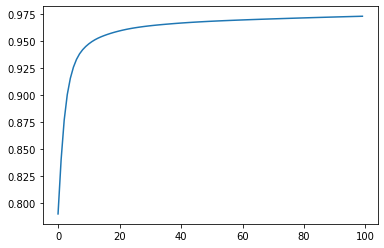

In [ ]:
plt.plot(nnet.error_trace);

In [ ]:
classes_test, probs_test = nnet.use(Xtest)

In [ ]:
confusion_matrix(classes_test, Ttest)

NameError: ignored

## CIFAR-10
Great, now, load a subset of the CIFAR-10 data and train your network again with the hyperparameters that worked best for MNIST. How well do the parameters work for this new dataset? 

# **I couldnt finish this part because I couldnt find the full address to curl the data**

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
data_batch_1 = unpickle('cifar-10-batches-py/data_batch_1')

FileNotFoundError: ignored

In [ ]:
data_batch_1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [ ]:
Xtrain = data_batch_1[b'data']
Ttrain = np.array(data_batch_1[b'labels']).reshape(-1,1)

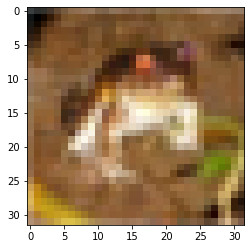

In [ ]:
image0 = Xtrain[0, :]
image0 = image0.reshape(3, 32, 32)
image0 = np.rollaxis(image0, 0, 3)
image0.shape

plt.imshow(image0);

In [ ]:
Xtrain = Xtrain.reshape(-1, 3, 32, 32)
Xtrain = np.rollaxis(Xtrain, 1, 4)

In [ ]:
Xtrain.shape

(10000, 32, 32, 3)

In [ ]:
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

X_train_gray = grayscale(Xtrain)

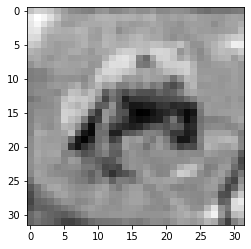

In [ ]:
image0 = X_train_gray[0, :].reshape(32,32)

plt.imshow(-image0, cmap='gray');

In [ ]:
test_batch = unpickle('cifar-10-batches-py/test_batch')

In [ ]:
Xtest = test_batch[b'data']
Ttest = np.array(test_batch[b'labels']).reshape(-1,1)

In [ ]:
Xtest = Xtest.reshape(-1, 3, 32, 32)
Xtest = np.rollaxis(Xtest, 1, 4)
X_test_gray = grayscale(Xtest)

In [ ]:
X_train_gray.shape, Ttrain.shape, X_test_gray.shape, Ttrain.shape

((10000, 32, 32, 1), (10000, 1), (10000, 32, 32, 1), (10000, 1))

In [ ]:
X_train_gray= X_train_gray.reshape(-1,32 * 32)
X_test_gray = X_test_gray.reshape(-1,32 * 32)

In [ ]:
X_train_gray.shape, Ttrain.shape, X_test_gray.shape, Ttrain.shape

((10000, 1024), (10000, 1), (10000, 1024), (10000, 1))

In [ ]:
X_train_gray.shape[1]

1024

In [ ]:
len(np.unique(Ttrain))

10

In [ ]:
nnet = NeuralNetworkClassifierCNN(X_train_gray.shape[1], [20, 20], len(np.unique(Ttrain)),
                                       patch_size=2, stride=2)
nnet.train(X_train_gray, Ttrain, n_epochs, learning_rate, method='adam', verbose=True)

Adam: Epoch 10 Error=0.81352
Adam: Epoch 20 Error=0.82172
Adam: Epoch 30 Error=0.82694
Adam: Epoch 40 Error=0.83118
Adam: Epoch 50 Error=0.83459
Adam: Epoch 60 Error=0.83709
Adam: Epoch 70 Error=0.83975
Adam: Epoch 80 Error=0.84173
Adam: Epoch 90 Error=0.84433
Adam: Epoch 100 Error=0.84626


NeuralNetworkClassifierCNN(1024, [20, 20], 10, 2, 2, 'tanh')

In [ ]:
X_train_gray.shape, Ttrain.shape, X_test_gray.shape, Ttrain.shape

((10000, 1024), (10000, 1), (10000, 1024), (10000, 1))

In [ ]:
cifar_predictions, cifar_probs = nnet.use(X_test_gray)

In [ ]:
confusion_matrix(cifar_predictions, Ttest)

,0,1,2,3,4,5,6,7,8,9
0,25.8,3.4,14.8,3.7,10.4,6.6,7.1,7.0,15.6,5.6
1,2.8,30.2,4.6,6.1,4.1,2.5,9.5,5.0,11.9,23.3
2,10.0,3.2,26.9,6.7,15.9,7.8,14.4,7.7,4.8,2.6
3,7.2,3.5,11.5,14.1,12.2,15.9,13.0,9.7,6.5,6.4
4,6.7,3.0,19.6,7.3,27.5,6.6,12.2,8.9,5.4,2.8
5,6.0,2.1,11.2,12.9,11.5,24.2,11.2,8.4,9.0,3.5
6,4.8,7.7,10.1,9.5,11.0,9.7,31.7,5.1,4.9,5.5
7,6.7,4.8,11.6,9.3,13.4,6.2,7.6,27.2,7.3,5.9
8,11.6,8.2,5.0,4.2,4.3,7.6,4.4,6.5,39.1,9.1
9,4.3,16.1,2.6,4.3,3.3,2.4,6.4,6.9,14.3,39.4


## Grading and Check-In

When ready, submit your notebook via the A4 link in our class Canvas web page. Your notebook must be named as Lastname-A4.ipynb.  

## Extra Credit
Earn 10 extra credit point on this assignment by doing the following.

1. Add the additional CIFAR-10 data into your training. Do things improve? Worsen? (5 points)
2. Train an equivalent CNN using pytorch, utilizing the GPU. Compare your accuracy and the speedup. (5 points) 